# Hankel Alternative View of Koopman (HAVOK)

In this tutorial, we demonstrate several basic use cases of the Hankel Alternative View of Koopman (HAVOK) approach [1] for modeling chaotic systems from partial measurements. In particular, we apply HAVOK to the chaotic Lorenz system and examine each of the following scenarios:

- Basic HAVOK application with ideal data
- Structured HAVOK (sHAVOK) for limited data
- Pairing HAVOK with BOP-DMD for noisy data
- HAVOK with multiple variables and chaos terms

We begin with some basic imports, including `numpy` for computations, `matplotlib` for plotting, `solve_ivp` for data simulation, and the `HAVOK` module of the PyDMD package for HAVOK applications.

- Summary plotting
- Threshold computing
- Data reconstruction
- Prediction with input forcing
- Viewing singular values and modes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from pydmd import HAVOK

## The Chaotic Lorenz System

Throughout this tutorial, we examine the Lorenz system

$$
\begin{cases}
\dot{x} = \sigma (y-x) \\
\dot{y} = x(\rho-z)-y \\ 
\dot{z} = xy - \beta z
\end{cases}
$$

for the parameters $(\sigma, \rho, \beta) = 10, 28, 8/3$ and the initial condition $(x_0, y_0, z_0) = (-8,8,27)$. Below we provide code that uses `scipy.integrate.solve_ivp` to propagate this system forward in time.

In [2]:
def generate_lorenz_data(t_eval):
    """
    Given a time vector t_eval = t1, t2, ..., evaluates and returns
    the snapshots of the Lorenz system as columns of the matrix X.
    """
    def lorenz_system(t, state):
        sigma, rho, beta = 10, 28, 8/3 # chaotic parameters
        x, y, z = state
        x_dot = sigma * (y - x)
        y_dot = (x * (rho - z)) - y
        z_dot = (x * y) - (beta * z)
        return [x_dot, y_dot, z_dot]

    # Set integrator keywords to replicate the odeint defaults
    integrator_keywords = {}
    integrator_keywords["rtol"] = 1e-12
    integrator_keywords["atol"] = 1e-12
    integrator_keywords["method"] = "LSODA"

    sol = solve_ivp(
        lorenz_system,
        [t_eval[0], t_eval[-1]],
        [-8, 8, 27],
        t_eval=t_eval,
        **integrator_keywords,
    )

    return sol.y

def get_ind_switch_lorenz(x):
    """
    Get indices of true lobe switching of the Lorenz system given x data.
    """
    ind_switch = np.sign(x[:-1]) - np.sign(x[1:]) != 0
    ind_switch = np.append(ind_switch, False)
    ind_switch = np.where(ind_switch)[0]

    return ind_switch

We start by simulating Lorenz data for the fine time step $\Delta t = 0.001$ over $m = 50000$ time points. We then


Note that this data set is quite ideal in that it is clean, finely-sampled, and abundant in data points. We will adjust these attributes as we advance.

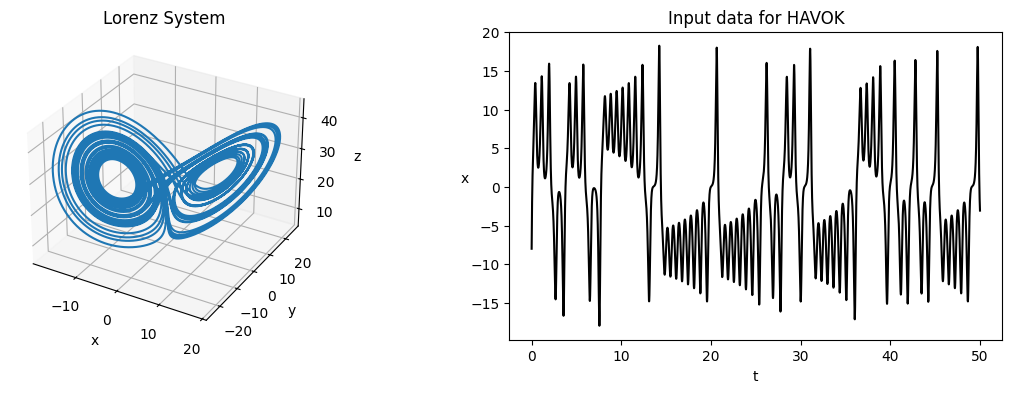

In [6]:
# Generate Lorenz system data.
dt = 0.001 # time step
m = 50000  # number of data samples
t = np.arange(m) * dt
X = generate_lorenz_data(t)
x = X[0]

# Plot the 3D attractor and the x time-series.
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(121, projection="3d")
ax.plot(X[0], X[1], X[2])
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax = fig.add_subplot(122)
ax.set_title("Input data for HAVOK")
ax.plot(t, x, c="k")
ax.set_xlabel("t")
ax.set_ylabel("x", rotation=0)
plt.show()

## Basic HAVOK application with ideal data

In order to apply HAVOK to your data, simply initialize a `HAVOK` model with your desired parameters and invoke the model's `fit` method. Note that input snapshots and time information are both necessary for model fitting. Once fitted, the `HAVOK`-specific `plot_summary` function may be used to visualize major HAVOK results.

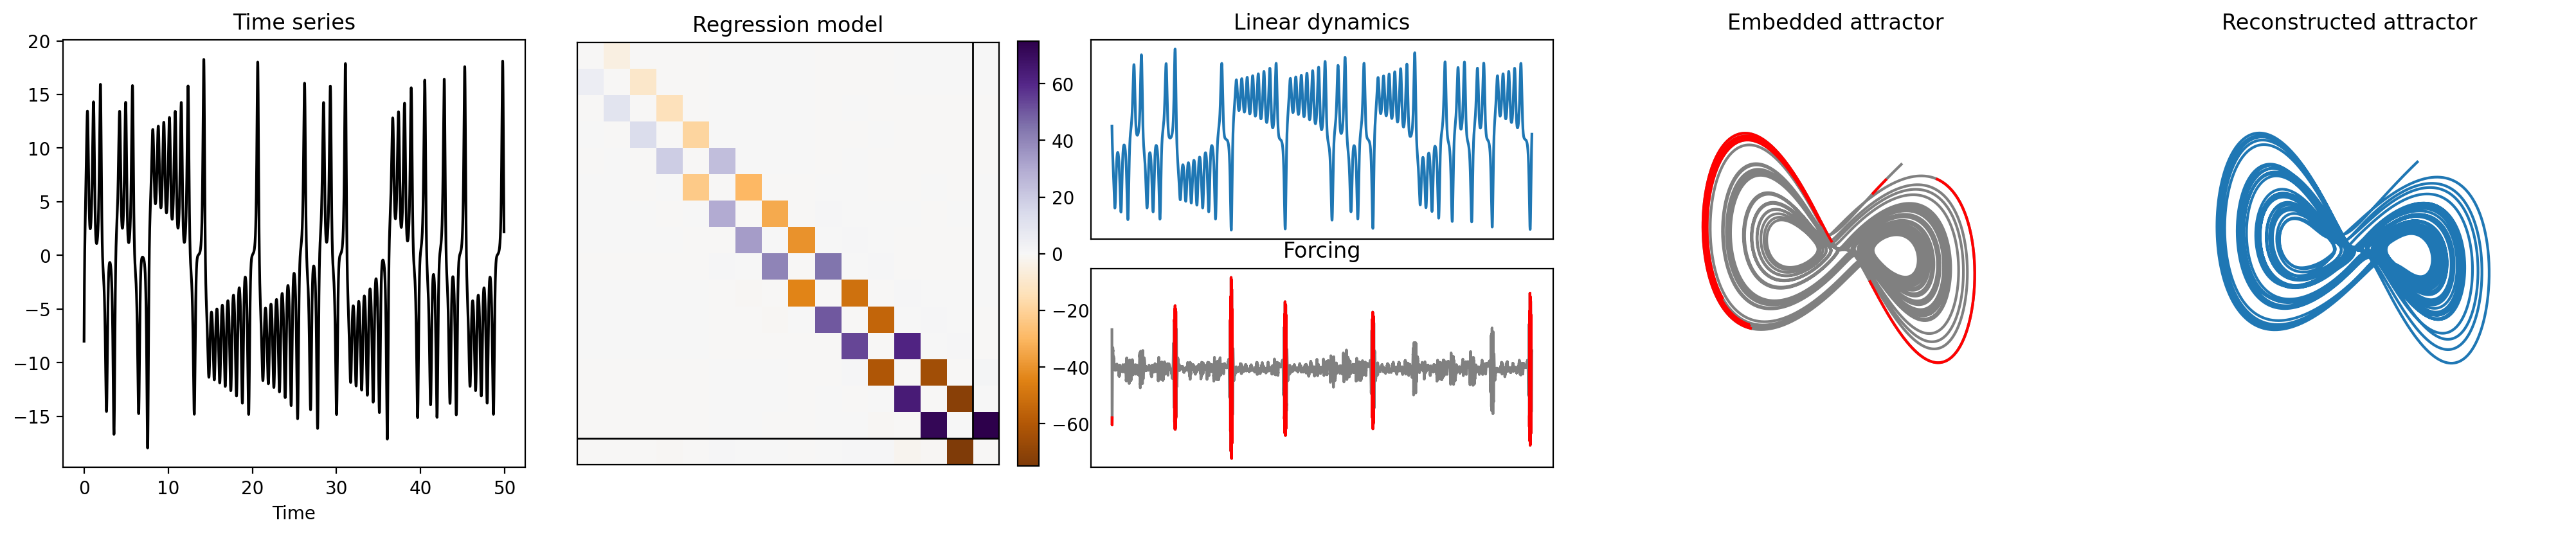

In [27]:
havok = HAVOK(svd_rank=16, delays=100)
havok.fit(x, t)
havok.plot_summary()

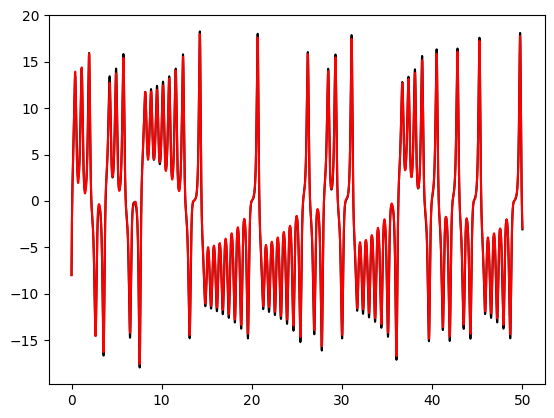

In [36]:
plt.figure()
plt.plot(t, x, c="k", label="Truth")
plt.plot(t, np.squeeze(havok.reconstructed_data), c="r", label="Reconstruction")
plt.show()

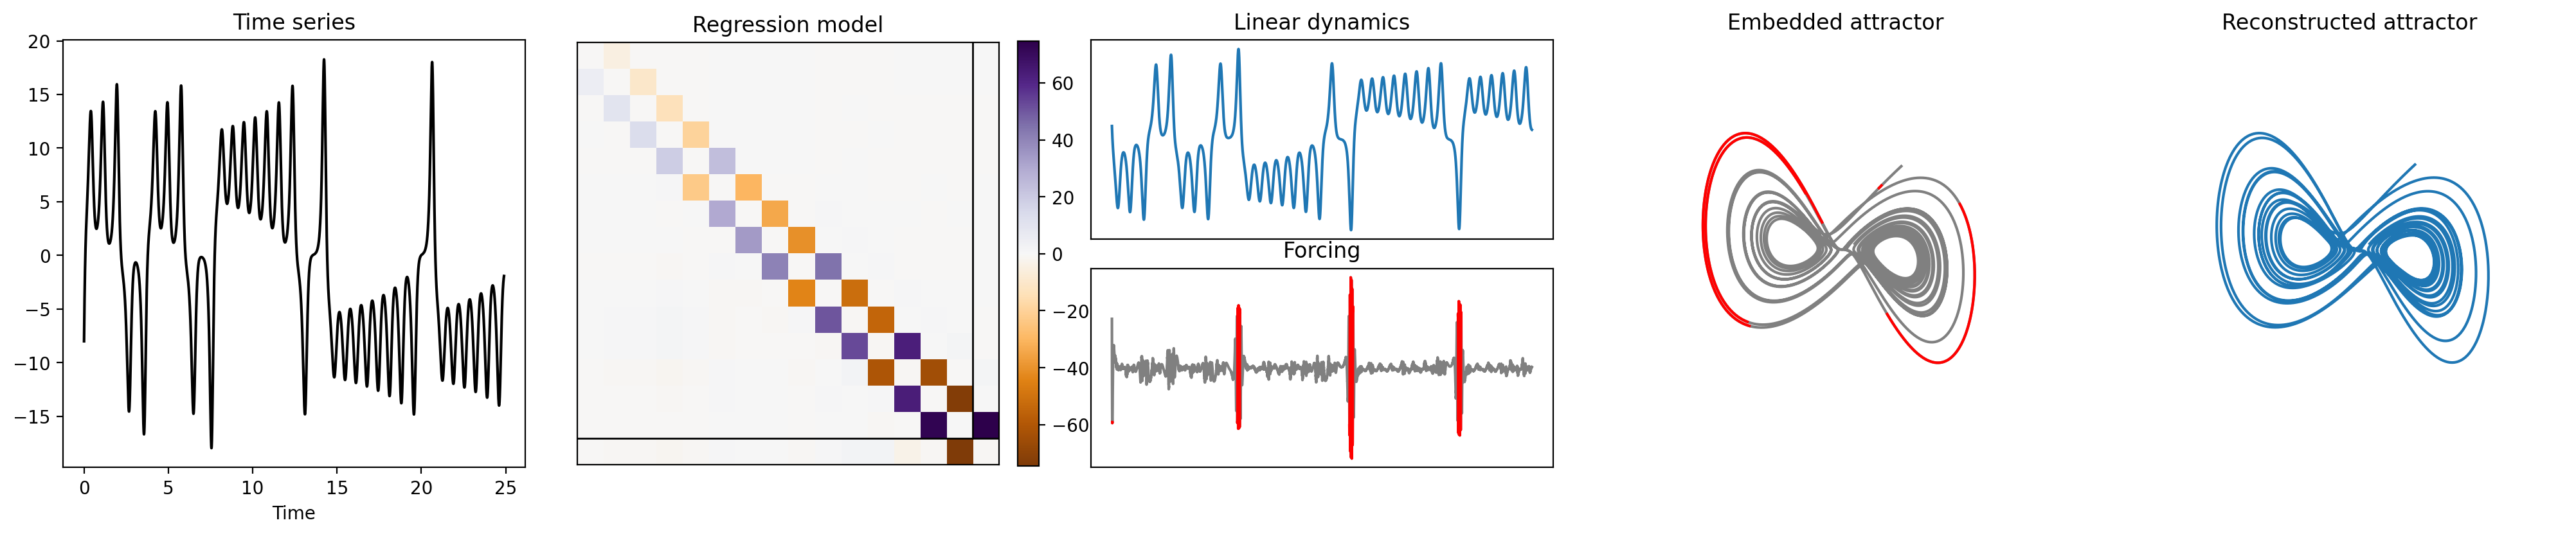

In [29]:
havok_short = HAVOK(svd_rank=16, delays=100)
havok_short.fit(x[:len(x)//2], t[:len(t)//2])
havok_short.plot_summary()

In [33]:
havok.forcing.shape

(49901, 1)

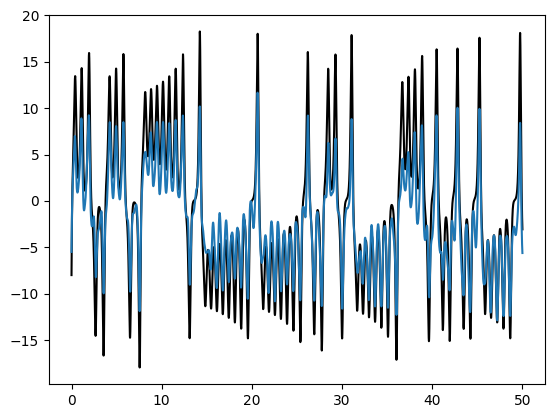

In [35]:
forcing_long = havok.forcing
time_long = t[:len(forcing_long)]
V0 = havok.linear_dynamics[0]

plt.plot(t, x, c="k")
plt.plot(t, np.squeeze(havok_short.predict(forcing_long, time_long, V0)))

Above, we adjust the `svd_rank` and the `delays` parameters, which are arguably the two most significant parameters of the HAVOK algorithm. `svd_rank` controls the rank of the fit, or essentially 

, while `delays` controls the number of time-delays


In [ ]:
delay_values = [50, 100, 200, 500]
rank_values = [4, 8, 16, 32]

plt.figure(figsize=(12, 3))
plt.suptitle("Impact of the number of delays $q$ on the HAVOK model")
for i, delays in enumerate(delay_values):
    havok = HAVOK(svd_rank=16, delays=delays)
    havok.fit(x, t)
    vmax = np.abs(havok.operator).max()
    plt.subplot(1, len(delay_values), i + 1)
    plt.title(f"$q \Delta t = {delays * dt}$")
    plt.imshow(havok.operator, vmax=vmax, vmin=-vmax, cmap="PuOr")
    plt.colorbar()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 3))
plt.suptitle("Impact of the rank $r$ on HAVOK model reconstructions")
for i, svd_rank in enumerate(rank_values):
    havok = HAVOK(svd_rank=svd_rank, delays=100)
    havok.fit(x, t)
    ax = fig.add_subplot(1, len(rank_values), i + 1, projection="3d")
    ax.set_title(f"$r = {svd_rank}$")
    ax.plot(
        havok.reconstructed_embeddings[:, 0],
        havok.reconstructed_embeddings[:, 1],
        havok.reconstructed_embeddings[:, 2],
    )
plt.tight_layout()
plt.show()

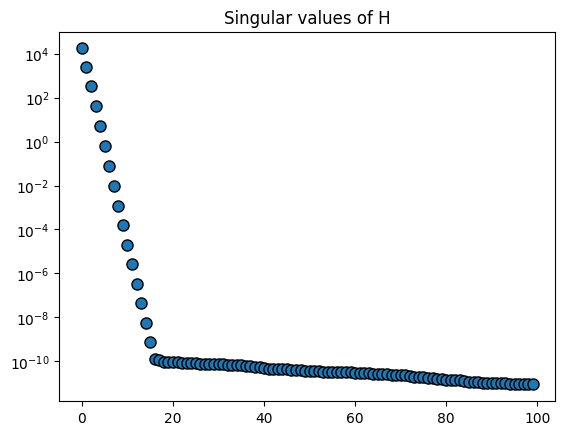

In [16]:
havok = HAVOK(svd_rank=-1, delays=100).fit(x, t)
plt.figure()
plt.title("Singular values of H")
plt.plot(havok.singular_vals, "o", mec="k", ms=8)
plt.semilogy()
plt.show()

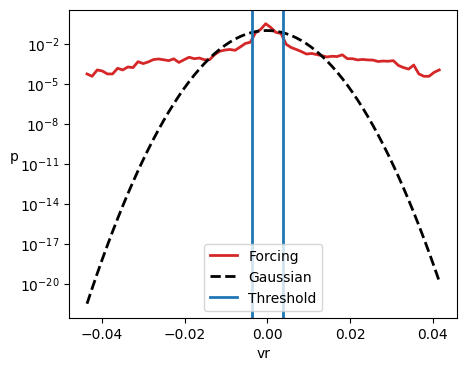

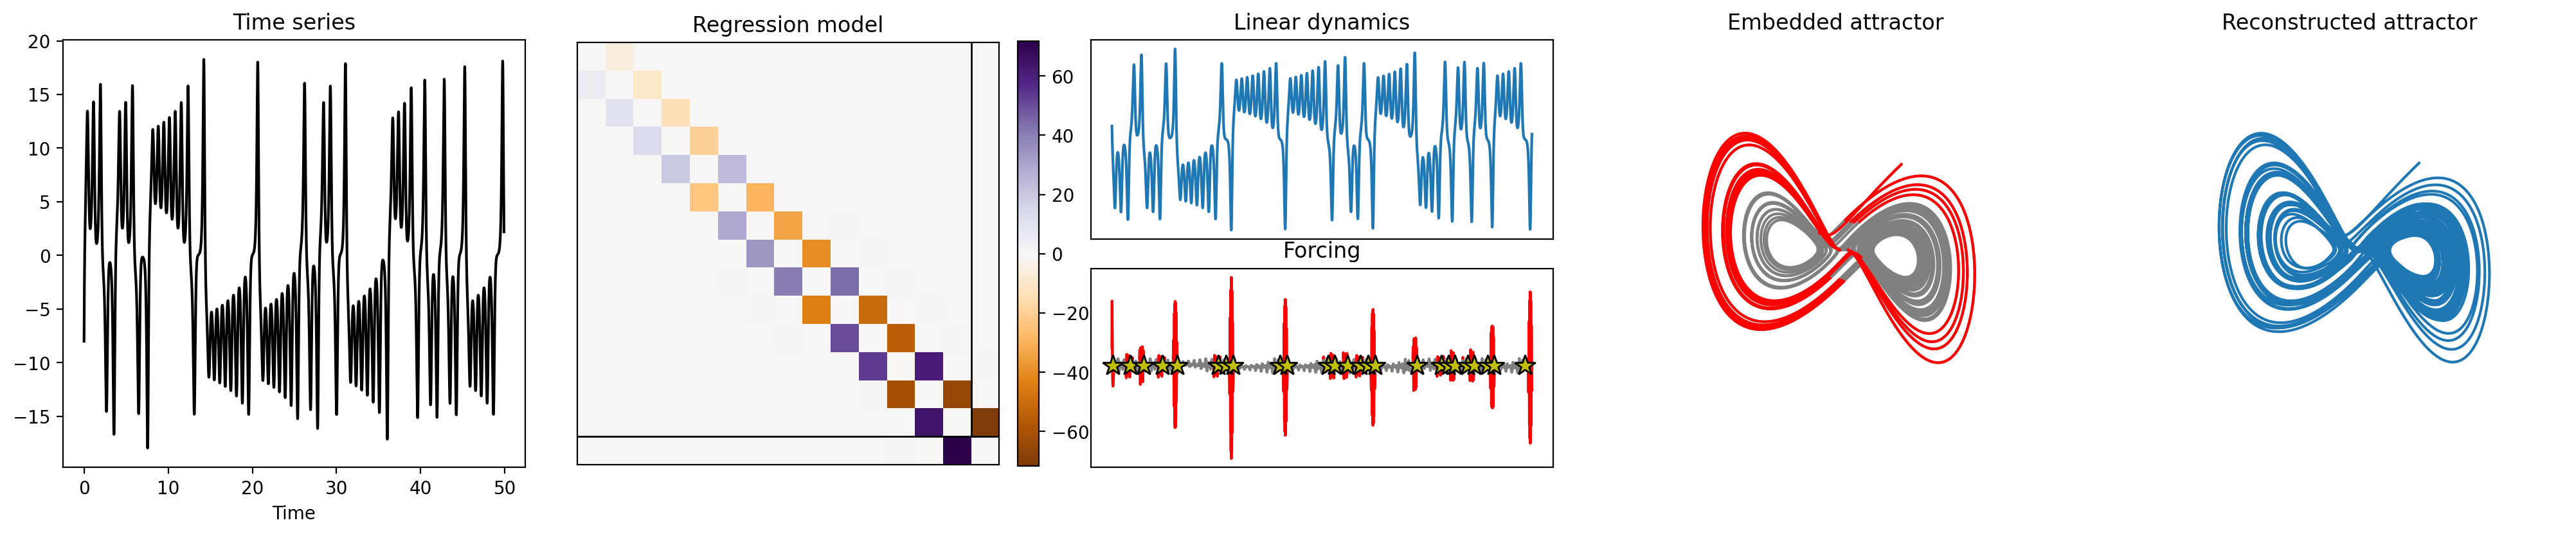

In [10]:
havok = HAVOK(svd_rank=15, delays=100).fit(x, t)
vr = havok.forcing[:, 0]
thres = havok.compute_threshold(vr, p=0.1, plot=True, bins=70)
havok.plot_summary(forcing_threshold=thres, true_switch_indices=get_ind_switch_lorenz(x))

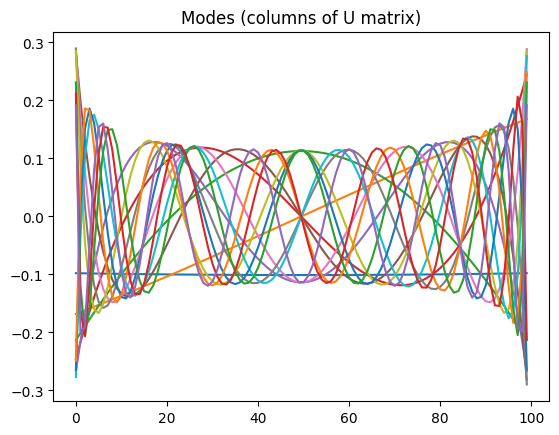

In [11]:
plt.figure()
plt.title("Modes (columns of U matrix)")
plt.plot(havok.modes)
plt.show()

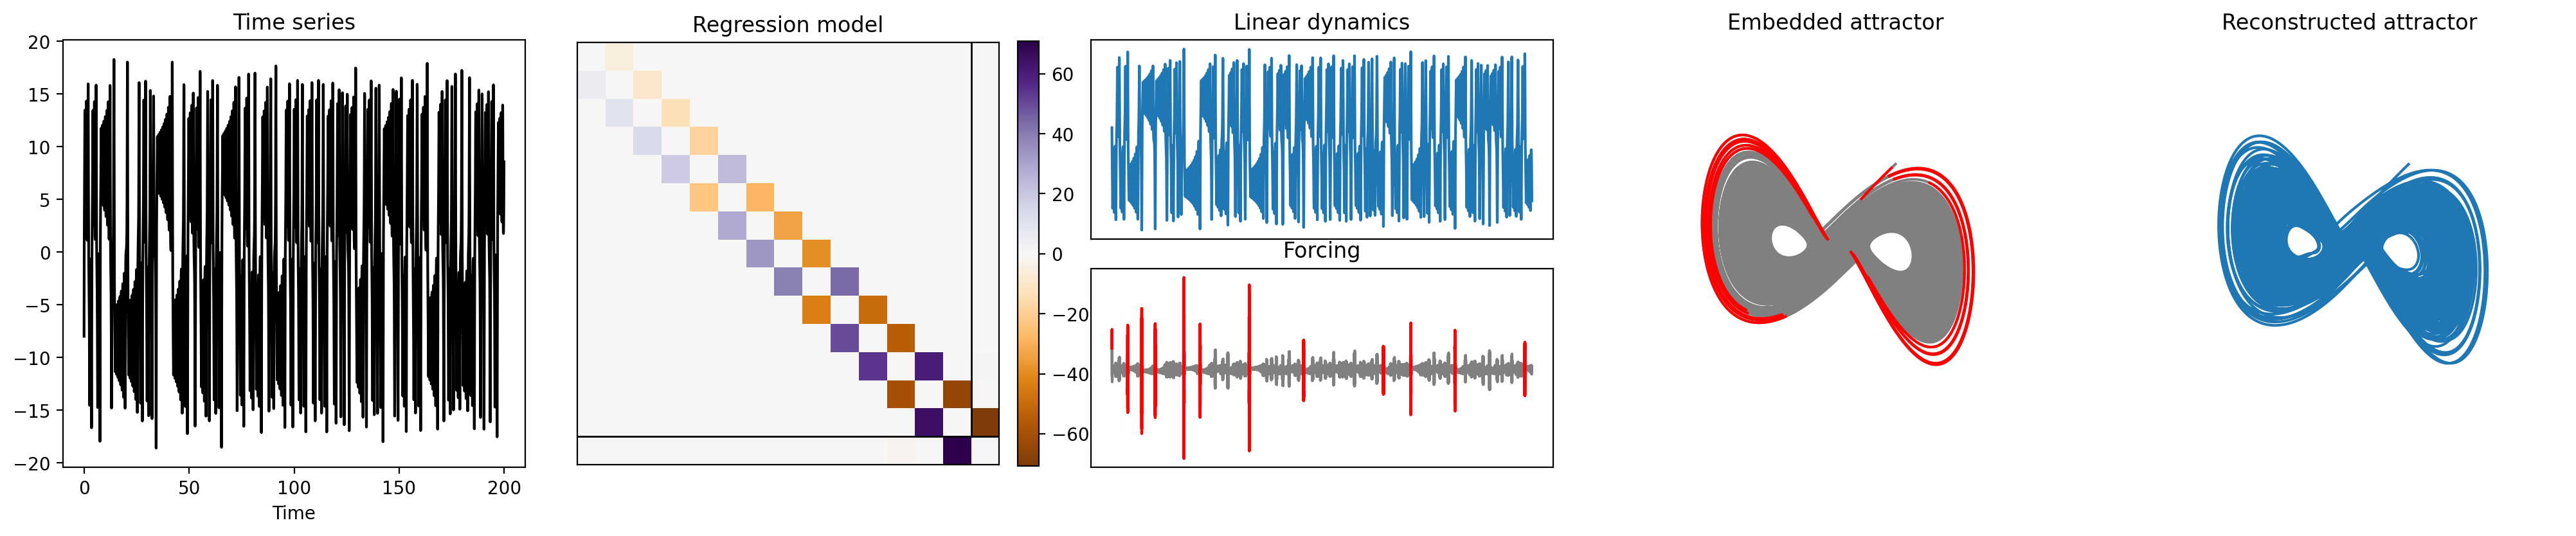

In [28]:
m_short = 200000
x_short = x[:m_short]
t_short = t[:m_short]

havok_full = HAVOK(svd_rank=15, delays=100)
havok_full.fit()

havok = HAVOK(svd_rank=15, delays=100)
havok.fit(x_short, t_short)

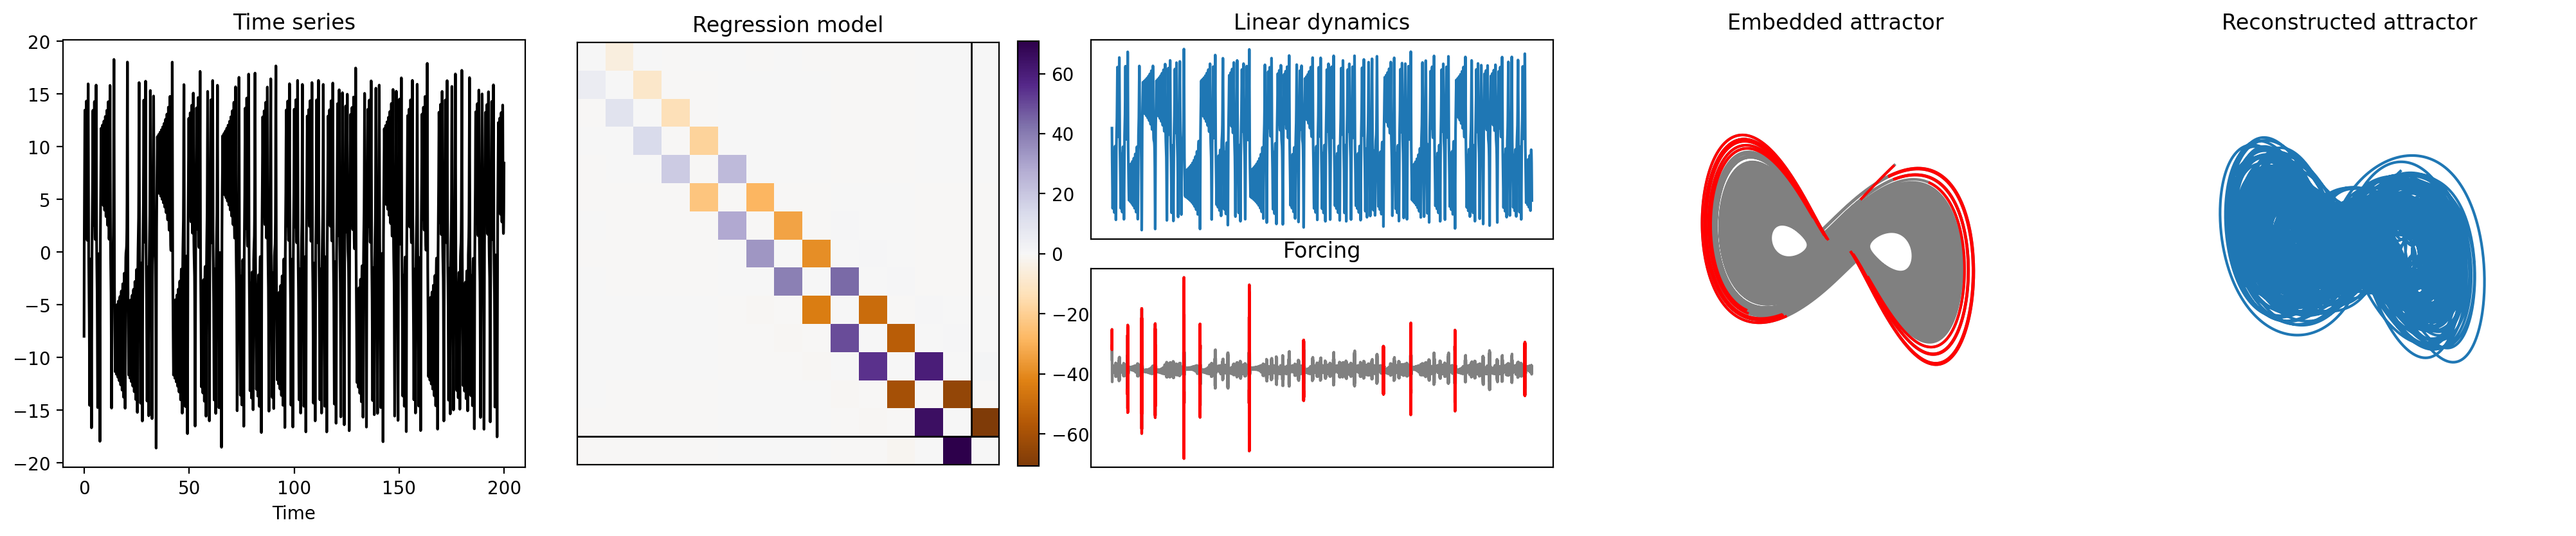

In [29]:
havok2 = HAVOK(svd_rank=15, delays=100, structured=True)
havok2.fit(x_short, t_short)
havok2.plot_summary()

## References:

[1] S. L. Brunton, B. W. Brunton, J. L. Proctor, E. Kaiser, and J. N. Kutz, *Chaos
as an intermittently forced linear system*, Nature Communications, 8 (2017), pp. 1–9. [https://doi.org/10.1038/s41467-017-00030-8](https://doi.org/10.1038/s41467-017-00030-8)

[2] S. M. Hirsh, S. M. Ichinaga, S. L. Brunton, J. N. Kutz, and B. W. Brunton,
*Structured time-delay models for dynamical systems with connections to frenet–serret frame*,
Proceedings of the Royal Society A, 477 (2021). art. 20210097. [http://doi.org/10.1098/rspa.2021.0097](http://doi.org/10.1098/rspa.2021.0097)